# Model for Image Classification of Cats and Dogs 
## 1. Import Modules 

In [1]:
import os
import sys
import glob
import random

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

os.environ['CUDA_VISIBLE_DEVICES']='1'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

tf_version=float('.'.join(tf.__version__.split('.')[0:2]))

if tf_version > 2.8:
    import keras.utils as image

else:
    from keras.preprocessing import image

path_list=os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')


from image_classification_functions import prep_data
from image_classification_functions import single_training_run
from image_classification_functions import plot_single_training_run
from image_classification_functions import hyperparameter_optimization_run
from image_classification_functions import plot_hyperparameter_optimization_run

tf.get_logger().setLevel('ERROR')


tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

## 2. Data Preparation 

In [2]:
training_data_path, validation_data_path, testing_data_path=prep_data()

training_dogs=glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats=glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs=glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats=glob.glob(f'{validation_data_path}/cats/cat.*')

Not running in Kaggle notebook
Checking data prep
Data prep already complete


### 2.1 Data Inspection 
#### 2.1.1 Training Data set 

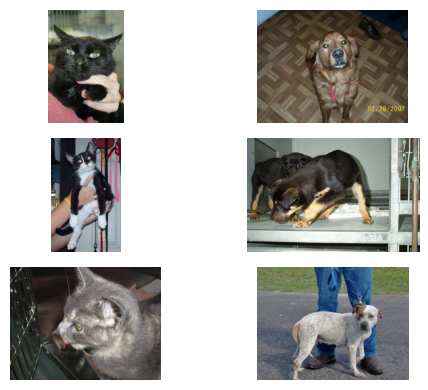

In [3]:

fig, axs=plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

#### 2.1.2 Validation Dataset 

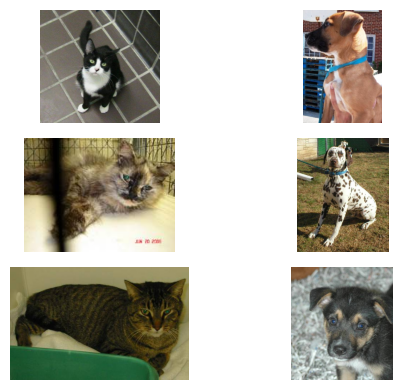

In [4]:

fig, axs=plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(validation_cats, validation_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

## 3. EDA 
### 3.1 Image data 

In [5]:

dog=image.load_img(training_dogs[0])

dog=image.img_to_array(dog)

print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (375, 499, 3)


- Image array has a shape of 375 x 499 x 3 pixels. 

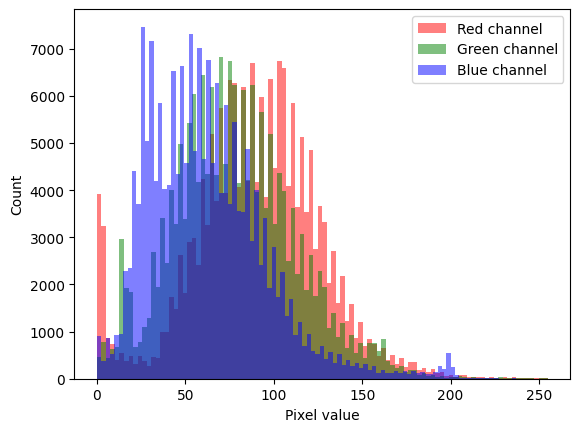

In [6]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

- Image array has 3 axes of 375 x 499 x 3: first two are the image dimensions and third is 3 color channels referring to primary colors red, blue and green 
- One image is has over half million values and one image is 10 times more data than any other data set we have worked so far! 
- Range of pixel value is 0 to 255 Standard JPEG image standard. 
Two options 
1. Scale pixel values - to improve neural net training. This can be done by adding normalization layer! 
2. Images can be made grey scale, thereby decreasing input size and reducing the computation burden by 3. This can be done by image dataset generator! 

### 3.2 Image dimensions 

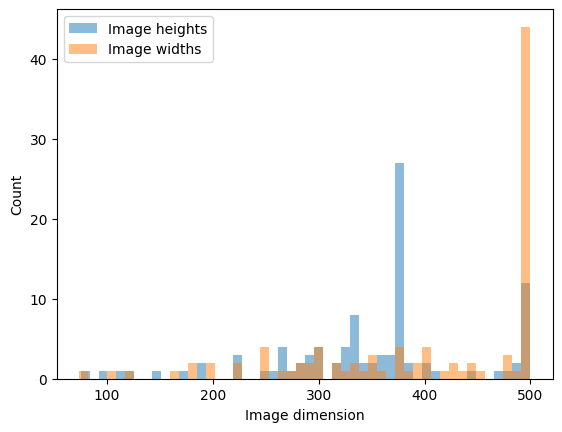

In [7]:

sample_size=100
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

heights=[]
widths=[]

for sample_image in sample:

    
    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)


    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])


plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

- Based on the above plot, image dimension can be set to 64 or 128 pixels. 
- Smaller is better for training speed and memory usage!
- Good balance should be found for proper model training! 



### 3.3 IMage Aspect ratio 

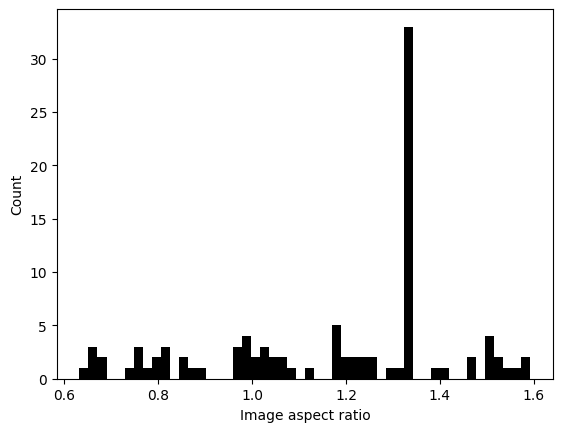

In [8]:

aspect_ratios=np.array(widths)/np.array(heights)

plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

- Most common aspect ratio is around 1.3 referring to 4:3 standard computer monitor! 
- Better to choose this aspect ratio in comparison to a smaller square input images! 

In [11]:
image_width=64
aspect_ratio=4/3
image_height=int(image_width / aspect_ratio)

## 4. Model 

Steps for Model build and training: 
1. Evaluate the baseline performance with default settings 
2. Optimize batch size and learning rate 
3. Optimize regularization with L1/L2 penalties 
4. Optimize input image size for speed and better performance 
5. Optimize network architecture 
6. Final model and evaluation 


In [12]:
epochs=5
steps_per_epoch=10
validation_steps=10

### 4.1 Baseline Model performance 

Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Training run already complete, loading results from disk.


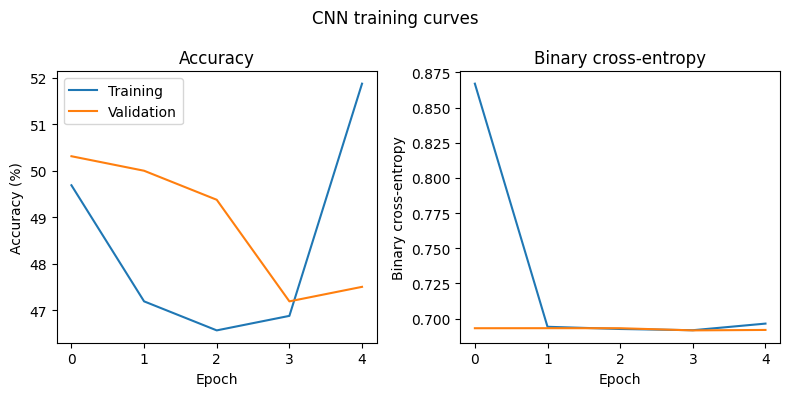


CPU times: user 1.04 s, sys: 509 ms, total: 1.55 s
Wall time: 1.32 s


In [13]:
%%time

training_results=single_training_run(
    training_data_path,
    validation_data_path,
    image_height=image_width,
    image_width=image_height,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    print_model_summary=True
)

plot_single_training_run(training_results).show()

print()

### 4.2 Batch size and learning rate optimization 

Optimization run already complete, loading results from disk.


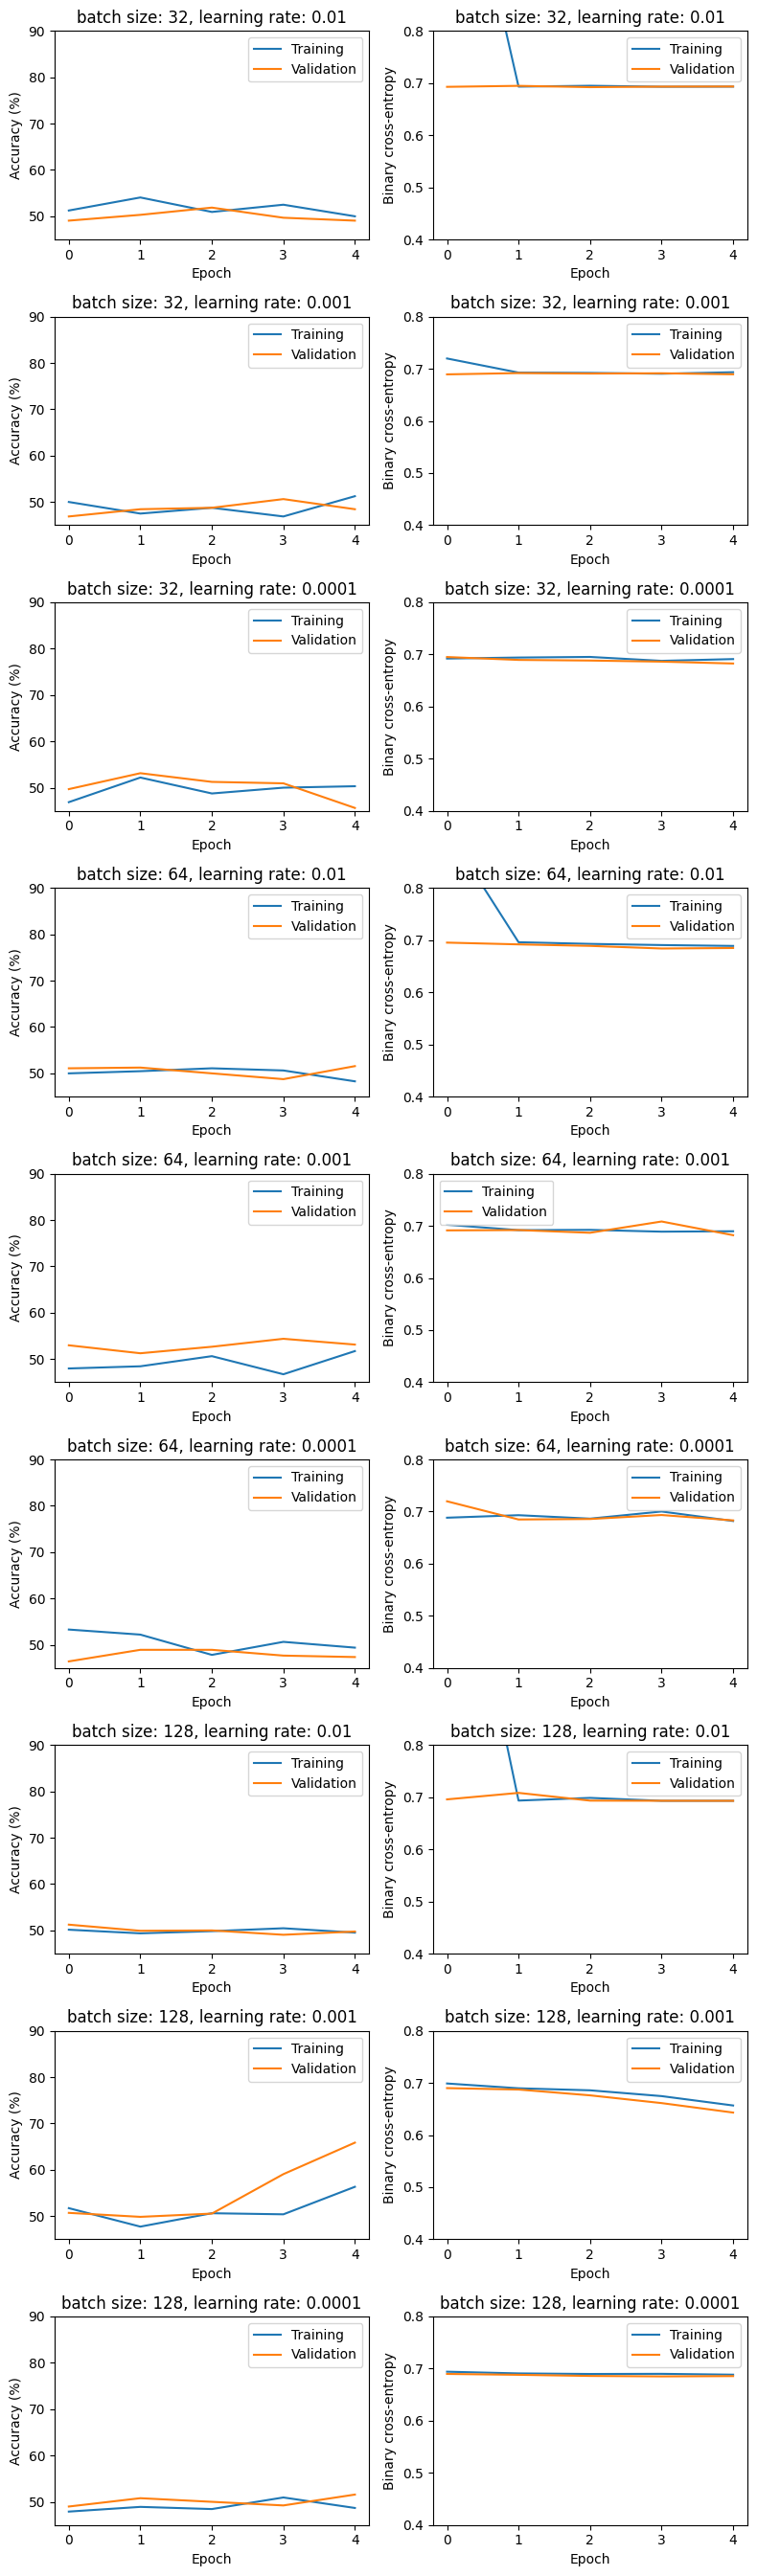


CPU times: user 3 s, sys: 133 ms, total: 3.13 s
Wall time: 3.29 s


In [14]:
%%time

# Define hyperparameters
hyperparameters={
    'batch_sizes': [32, 64, 128],
    'learning_rates': [0.01, 0.001, 0.0001],
    'image_widths': [image_width],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': epochs
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['batch_sizes', 'learning_rates']

# Plot the learning curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,90],
    entropy_ylims=[0.4,0.8]
).show()

print()

In [15]:
batch_size=128
learning_rate=0.0001

Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Training run already complete, loading results from disk.


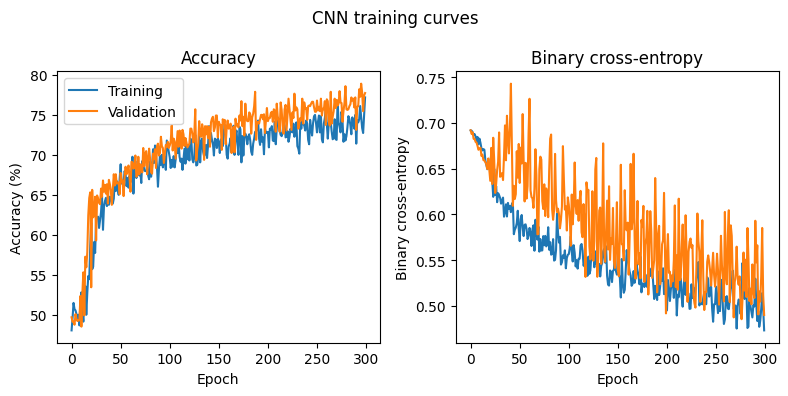


CPU times: user 1.06 s, sys: 371 ms, total: 1.43 s
Wall time: 1.29 s


In [16]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'image_width': image_width,
    'image_height': image_height,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 300
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 4.3 Regularization 
Optimize L1 and L2 penalties using optimized batch size and learning rate from previous experiment! 

Optimization run already complete, loading results from disk.


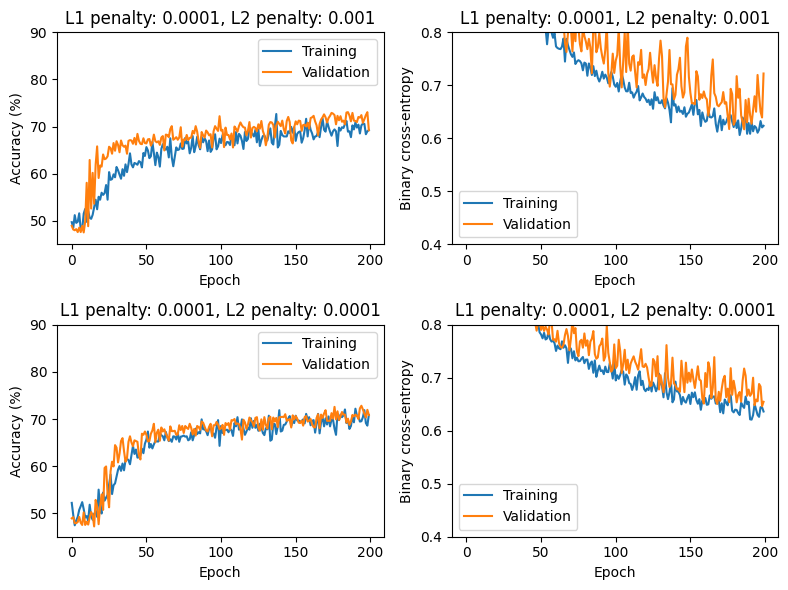


CPU times: user 703 ms, sys: 20.4 ms, total: 723 ms
Wall time: 797 ms


In [17]:
%%time

# Define hyperparameters
hyperparameters={
    'l1_penalties': [ 0.0001],
    'l2_penalties': [0.001, 0.0001],
    'batch_sizes': [batch_size],
    'learning_rates': [learning_rate],
    'image_widths': [image_width],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 200
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['l1_penalties', 'l2_penalties']

# Plot the learning curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,90],
    entropy_ylims=[0.4,0.8]
).show()

print()

In [18]:
l1_penalty=0.0001
l2_penalty=0.0001

Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Training run already complete, loading results from disk.


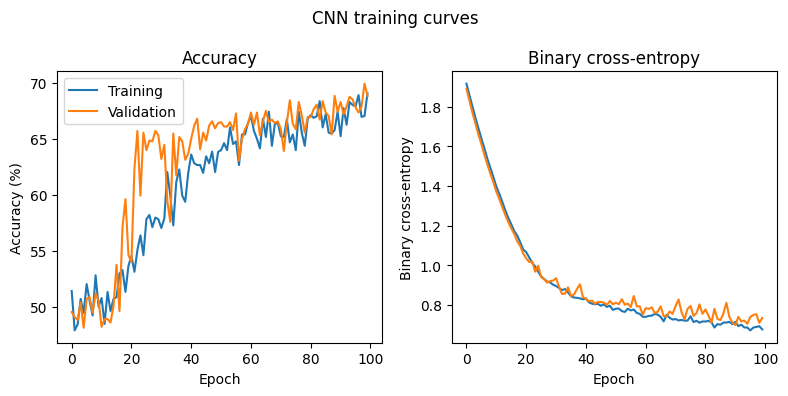


CPU times: user 1.02 s, sys: 398 ms, total: 1.42 s
Wall time: 1.23 s


In [19]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'image_width': image_width,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 100
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters,
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 4.4 Input Image size optimization 

Starting training run 1 of 2
Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Starting training run 2 of 2
Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


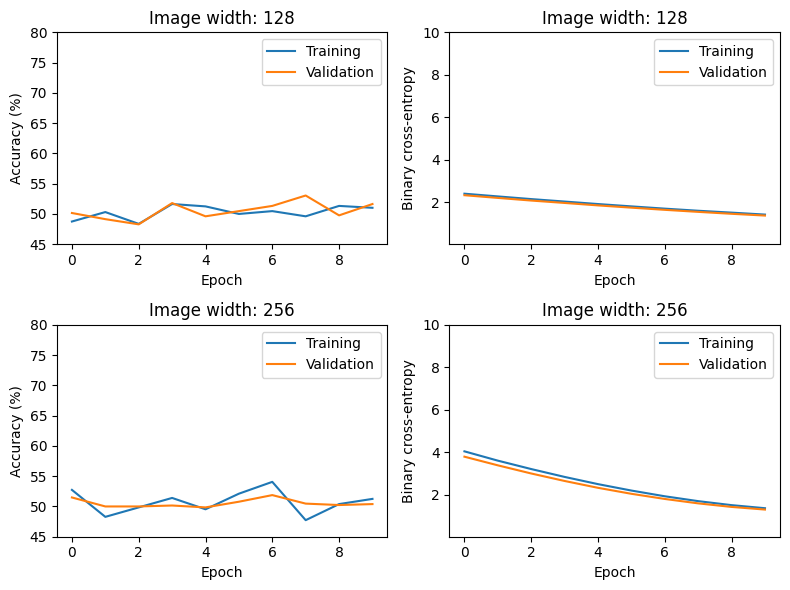


CPU times: user 18min 38s, sys: 1min 8s, total: 19min 47s
Wall time: 12min 37s


In [21]:
%%time

# Define hyperparameters
hyperparameters={
    'l1_penalties': [l1_penalty],
    'l2_penalties': [l2_penalty],
    'batch_sizes': [batch_size],
    'learning_rates': [learning_rate],
    'image_widths': [128, 256],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 10
}

# Train the model with each combination of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['image_widths']

# Plot the training curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,80],
    entropy_ylims=[0.01,10.0]
).show()

print()

In [22]:
image_width=256
image_height=int(image_width/aspect_ratio)

Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


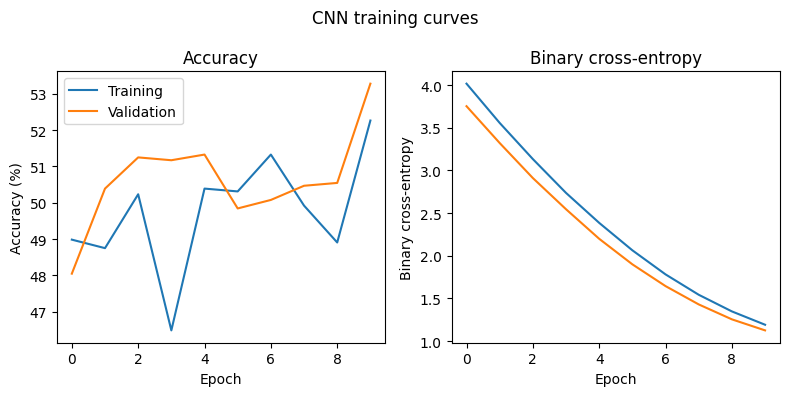


CPU times: user 14min 34s, sys: 54.9 s, total: 15min 29s
Wall time: 9min 18s


In [23]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'image_height': image_height,
    'image_width': image_width,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 10
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters)

# Plot the results
plot_single_training_run(training_results).show()

print()

## 